 ## Importing The Modules        

In [73]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.base import TransformerMixin
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import joblib
from sklearn.pipeline import Pipeline
import seaborn as sns

In [74]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = None

## Reading the Data


In [75]:
multidf = pd.read_excel('Datathon_Uretim_Tahmini_Verisi.xlsx',sheet_name=[0,1,2,3])

In [76]:
forecastdf = multidf[0]
actualdf = multidf[1]
availabilitydf = multidf[2]
inputdf = multidf[3]

In [77]:
forecastdf.head()

,Datekey,Hour,ProviderId,WindSpeed,WindDirection,Temperature,Pressure,Humidity,Power Forecast
0,20210601,00:00:00,1,3.50,12.00,13.90,99384,93.010,6.608
1,20210601,00:00:00,2,2.81,47.88,15.17,99493,0.985,12.375
2,20210601,00:00:00,3,4.80,30.00,16.00,95700,0.920,11.038
3,20210601,01:00:00,1,3.40,3.00,13.80,99364,93.150,6.628
4,20210601,01:00:00,2,2.87,47.78,14.92,99463,0.986,11.819


In [78]:
actualdf.head()

,PowerDate,PowerDateKey,PowerHour,Actual Generation
0,2021-06-01,20210601,00:00:00,21.378
1,2021-06-01,20210601,01:00:00,17.391
2,2021-06-01,20210601,02:00:00,54.585
3,2021-06-01,20210601,03:00:00,50.111
4,2021-06-01,20210601,04:00:00,60.271


# Merging the Data


In [79]:
merged_df = forecastdf.merge(actualdf,left_on=['Datekey','Hour'],right_on=['PowerDateKey','PowerHour']) \
            .merge(availabilitydf,left_on=['Datekey','Hour'],right_on=['AvailabilityDateKey','AvailabilityHour'])

In [80]:
merged_df.head()

,Datekey,Hour,ProviderId,WindSpeed,WindDirection,Temperature,Pressure,Humidity,Power Forecast,PowerDate,PowerDateKey,PowerHour,Actual Generation,AvailabilityDateKey,AvailabilityDate,AvailabilityHour,RealAvailabilityPerc (%)
0,20210601,00:00:00,1,3.50,12.00,13.90,99384,93.010,6.608,2021-06-01,20210601,00:00:00,21.378,20210601,2021-06-01,00:00:00,95.89
1,20210601,00:00:00,2,2.81,47.88,15.17,99493,0.985,12.375,2021-06-01,20210601,00:00:00,21.378,20210601,2021-06-01,00:00:00,95.89
2,20210601,00:00:00,3,4.80,30.00,16.00,95700,0.920,11.038,2021-06-01,20210601,00:00:00,21.378,20210601,2021-06-01,00:00:00,95.89
3,20210601,01:00:00,1,3.40,3.00,13.80,99364,93.150,6.628,2021-06-01,20210601,01:00:00,17.391,20210601,2021-06-01,01:00:00,86.55
4,20210601,01:00:00,2,2.87,47.78,14.92,99463,0.986,11.819,2021-06-01,20210601,01:00:00,17.391,20210601,2021-06-01,01:00:00,86.55


# Drop unnecessary columns

In [81]:
drop_columns=['PowerDate','PowerDateKey','PowerHour','AvailabilityDateKey','AvailabilityDate','AvailabilityHour']

In [82]:
merged_df = merged_df.drop(columns = drop_columns)

In [83]:
merged_df

,Datekey,Hour,ProviderId,WindSpeed,WindDirection,Temperature,Pressure,Humidity,Power Forecast,Actual Generation,RealAvailabilityPerc (%)
0,20210601,00:00:00,1,3.50,12.00,13.90,99384,93.010,6.608,21.378,95.89
1,20210601,00:00:00,2,2.81,47.88,15.17,99493,0.985,12.375,21.378,95.89
2,20210601,00:00:00,3,4.80,30.00,16.00,95700,0.920,11.038,21.378,95.89
3,20210601,01:00:00,1,3.40,3.00,13.80,99364,93.150,6.628,17.391,86.55
4,20210601,01:00:00,2,2.87,47.78,14.92,99463,0.986,11.819,17.391,86.55
...,...,...,...,...,...,...,...,...,...,...,...
24151,20220531,22:00:00,2,2.85,36.00,19.58,99999,0.957,32.552,46.288,98.75
24152,20220531,22:00:00,3,6.50,30.00,19.00,96200,0.830,53.034,46.288,98.75
24153,20220531,23:00:00,1,7.30,36.00,19.20,100208,84.310,37.983,38.540,98.28
24154,20220531,23:00:00,2,3.00,33.49,19.16,100022,0.970,30.641,38.540,98.28


# Upscaling the Generations

In [84]:
merged_df['Upscaled Generation'] = merged_df['Actual Generation']*100/merged_df['RealAvailabilityPerc (%)']


# Creating New Feature From Forecast and Upscaled Generation 

In [85]:
merged_df['Deviation'] = (- merged_df['Upscaled Generation'] + merged_df['Power Forecast'])/merged_df['Upscaled Generation']

# Na Values Filled With 1 

In [86]:
merged_df['Deviation'] = merged_df['Deviation'].fillna(1)

In [87]:
merged_df.loc[merged_df['Deviation'] == np.inf,'Deviation'] = 1

In [88]:
merged_df

,Datekey,Hour,ProviderId,WindSpeed,WindDirection,Temperature,Pressure,Humidity,Power Forecast,Actual Generation,RealAvailabilityPerc (%),Upscaled Generation,Deviation
0,20210601,00:00:00,1,3.50,12.00,13.90,99384,93.010,6.608,21.378,95.89,22.294296,-0.703601
1,20210601,00:00:00,2,2.81,47.88,15.17,99493,0.985,12.375,21.378,95.89,22.294296,-0.444925
2,20210601,00:00:00,3,4.80,30.00,16.00,95700,0.920,11.038,21.378,95.89,22.294296,-0.504896
3,20210601,01:00:00,1,3.40,3.00,13.80,99364,93.150,6.628,17.391,86.55,20.093588,-0.670144
4,20210601,01:00:00,2,2.87,47.78,14.92,99463,0.986,11.819,17.391,86.55,20.093588,-0.411802
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24151,20220531,22:00:00,2,2.85,36.00,19.58,99999,0.957,32.552,46.288,98.75,46.873924,-0.305541
24152,20220531,22:00:00,3,6.50,30.00,19.00,96200,0.830,53.034,46.288,98.75,46.873924,0.131418
24153,20220531,23:00:00,1,7.30,36.00,19.20,100208,84.310,37.983,38.540,98.28,39.214489,-0.031404
24154,20220531,23:00:00,2,3.00,33.49,19.16,100022,0.970,30.641,38.540,98.28,39.214489,-0.218631


In [89]:
y = merged_df['Deviation'].value_counts()

# Check if there is a Connection Between Deviation WindSpeed


<AxesSubplot:>

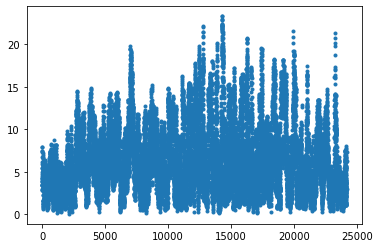

In [90]:
merged_df['WindSpeed'].plot(style='.')

<AxesSubplot:>

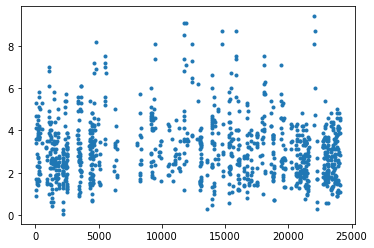

In [32]:
merged_df.loc[merged_df['Deviation']>20,'WindSpeed'].plot(style='.')

In [34]:
merged_df[merged_df['Deviation']>50].tail()

,Datekey,Hour,ProviderId,WindSpeed,WindDirection,Temperature,Pressure,Humidity,Power Forecast,Actual Generation,RealAvailabilityPerc (%),Upscaled Generation,Sapma
23986,20220529,15:00:00,2,2.48,55.37,30.88,99213,0.861,9.485,0.057,98.95,0.057605,163.656272
23987,20220529,15:00:00,3,4.10,60.00,26.00,95700,0.470,23.532,0.057,98.95,0.057605,407.507263
24054,20220530,14:00:00,1,4.60,280.00,27.30,99538,49.610,4.913,0.001,93.55,0.001069,4595.111500
24055,20220530,14:00:00,2,2.83,343.20,25.99,99524,0.849,5.388,0.001,93.55,0.001069,5039.474000
24056,20220530,14:00:00,3,4.50,315.00,23.00,95800,0.460,10.660,0.001,93.55,0.001069,9971.430000


## Correlations with Heatmap


<AxesSubplot:>

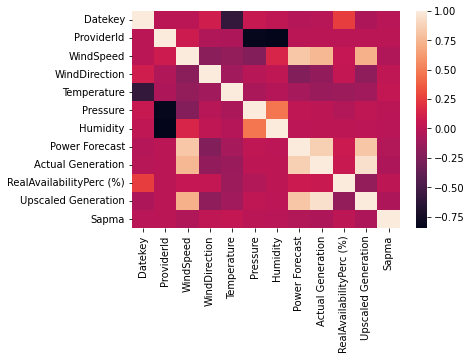

In [151]:
sns.heatmap(merged_df.corr())

## Corelations with Actual Generation

In [91]:
merged_df.corr()['Actual Generation']

Datekey                    -1.242841e-02
ProviderId                  5.000548e-16
WindSpeed                   7.534725e-01
WindDirection              -1.716171e-01
Temperature                -1.352281e-01
Pressure                    1.266046e-02
Humidity                    1.249898e-02
Power Forecast              8.577351e-01
Actual Generation           1.000000e+00
RealAvailabilityPerc (%)    6.135360e-02
Upscaled Generation         9.468032e-01
Deviation                  -6.173181e-02
Name: Actual Generation, dtype: float64

## Creation of Filters for Time-Series Analysis Based on PowerForecast and WindSpeed datas.



In [36]:
inputdf['PowerForecast'].max()

68.061

In [37]:
inputdf['PowerForecast'].min()

34.396

In [38]:
inputdf['WindSpeed'].max()

11.0

In [39]:
inputdf['WindSpeed'].min()

4.26

In [40]:
merged_df.tail()

,Datekey,Hour,ProviderId,WindSpeed,WindDirection,Temperature,Pressure,Humidity,Power Forecast,Actual Generation,RealAvailabilityPerc (%),Upscaled Generation,Sapma
24151,20220531,22:00:00,2,2.85,36.00,19.58,99999,0.957,32.552,46.288,98.75,46.873924,-0.305541
24152,20220531,22:00:00,3,6.50,30.00,19.00,96200,0.830,53.034,46.288,98.75,46.873924,0.131418
24153,20220531,23:00:00,1,7.30,36.00,19.20,100208,84.310,37.983,38.540,98.28,39.214489,-0.031404
24154,20220531,23:00:00,2,3.00,33.49,19.16,100022,0.970,30.641,38.540,98.28,39.214489,-0.218631
24155,20220531,23:00:00,3,6.30,30.00,19.00,96200,0.850,48.335,38.540,98.28,39.214489,0.232580


## The PowerForecast values were filtered according to the values we found.



In [92]:
filtered_df = merged_df[(merged_df['Power Forecast']<70) & (merged_df['Power Forecast']>30)]

## ProviderId2's Deviation values were too high 

In [93]:
filtered_df.loc[filtered_df['Deviation']>2,'ProviderId'].value_counts()

2    273
1     91
3     80
Name: ProviderId, dtype: int64

# It was decided not to include ProviderId2 in the model. 

In [94]:
filtered_df = filtered_df[filtered_df['ProviderId'] != 2]

# After we deleted ProviderId2 Deviation values were decreased


<AxesSubplot:>

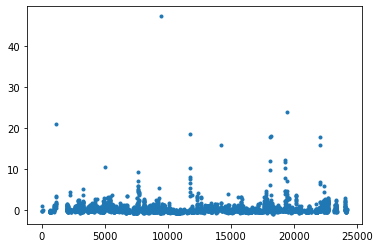

In [96]:
filtered_df.loc[filtered_df['Deviation']<50,'Deviation'].plot(style='.')

## May June July months were chosen due to the seasonality of wind energy production.

In [98]:
filtered_df = filtered_df[(filtered_df['Datekey']<20210801) | (filtered_df['Datekey']>20220500)]

<AxesSubplot:>

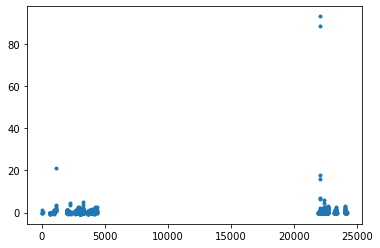

In [99]:
filtered_df['Deviation'].plot(style='.')

In [100]:
df2 = filtered_df.copy()

In [101]:
df_test = inputdf.copy()

## Creating Features for Time Series Analysis


In [113]:
def create_features(df, label=None):
    df['dayofweek'] = df['Datekey'].dt.dayofweek
    df['quarter'] = df['Datekey'].dt.quarter
    df['month'] = df['Datekey'].dt.month
    df['year'] = df['Datekey'].dt.year
    df['dayofyear'] = df['Datekey'].dt.dayofyear
    df['dayofmonth'] = df['Datekey'].dt.day
    df['weekofyear'] = df['Datekey'].dt.weekofyear
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [114]:
df2['Datekey'] = pd.to_datetime(df2['Datekey'].astype(str).str[:10])
df2.head()

,Datekey,Hour,ProviderId,WindSpeed,WindDirection,Temperature,Pressure,Humidity,Power Forecast,Actual Generation,RealAvailabilityPerc (%),Upscaled Generation,Deviation,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
24,2021-06-01,08:00:00,1,5.9,343.0,13.9,99532,92.74,34.968,39.090,96.71,40.419812,-0.134880,1,2,6,2021,152,1,22
27,2021-06-01,09:00:00,1,6.6,346.0,14.1,99546,92.11,32.014,37.697,96.71,38.979423,-0.178695,1,2,6,2021,152,1,22
29,2021-06-01,09:00:00,3,7.2,330.0,13.0,95700,0.84,30.272,37.697,96.71,38.979423,-0.223385,1,2,6,2021,152,1,22
30,2021-06-01,10:00:00,1,7.0,345.0,14.4,99564,91.97,40.648,18.941,96.16,19.697379,1.063625,1,2,6,2021,152,1,22
96,2021-06-02,08:00:00,1,5.7,340.0,13.1,100228,77.97,30.848,26.973,94.51,28.539837,0.080875,2,2,6,2021,153,2,22


In [115]:
df_test['Datekey'] = pd.to_datetime(df_test['Datekey'].astype(str).str[:10])
df_test.head()

,Datekey,Hour,ProviderId,WindSpeed,WindDirection,Temperature,Pressure,Humidity,PowerForecast
0,2022-06-04,00:00:00,1,9.40,34.00,17.60,99875,93.830,57.601
1,2022-06-04,00:00:00,2,4.86,21.27,18.85,100045,0.978,50.297
2,2022-06-04,00:00:00,3,8.10,30.00,18.00,96300,0.920,46.286
3,2022-06-04,01:00:00,1,9.30,32.00,17.60,99864,93.670,57.539
4,2022-06-04,01:00:00,2,4.93,21.81,18.82,100054,0.979,50.091


In [116]:
df2_c = create_features(df2)

C:\Users\enes_\AppData\Local\Temp\ipykernel_10728\2488819214.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Datekey'].dt.weekofyear


In [117]:
df9= pd.concat([dfc,df_test],axis=1)

NameError: name 'dfc' is not defined

In [118]:
df9 = df9.drop(columns=['Datekey'])

NameError: name 'df9' is not defined

In [120]:
df9['hour'] = df9['hour'].astype(str)
df9['hour'] = df9['hour'].astype(str).str[:2]
df9 = df9.drop(columns=['Hour'])

NameError: name 'df9' is not defined

In [124]:
df9 = df9[df9['ProviderId'] != 2]

NameError: name 'df9' is not defined

In [125]:
df9['hour'] = df9['hour'].astype(int)

NameError: name 'df9' is not defined

In [337]:
df9.shape

(48, 15)

In [338]:
X_train.shape

(880, 15)

In [179]:
def create_features(df, label=None):
    df['hour'] = df['Hour']
    df['dayofweek'] = df['Datekey'].dt.dayofweek
    df['quarter'] = df['Datekey'].dt.quarter
    df['month'] = df['Datekey'].dt.month
    df['year'] = df['Datekey'].dt.year
    df['dayofyear'] = df['Datekey'].dt.dayofyear
    df['dayofmonth'] = df['Datekey'].dt.day
    df['weekofyear'] = df['Datekey'].dt.weekofyear
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [180]:
df3 = create_features(df2)
X_train, y_train = create_features(data_train, label='number')
X_test, y_test = create_features(data_test, label='number')
X_train
Upscaled Generation

/var/folders/62/w43vm99x0js0czbjx16552nm0000gn/T/ipykernel_18596/1749859428.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Datekey'].dt.weekofyear


In [181]:
df3

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
24,08:00:00,1,2,6,2021,152,1,22
27,09:00:00,1,2,6,2021,152,1,22
29,09:00:00,1,2,6,2021,152,1,22
30,10:00:00,1,2,6,2021,152,1,22
96,08:00:00,2,2,6,2021,153,2,22
...,...,...,...,...,...,...,...,...
24149,21:00:00,1,2,5,2022,151,31,22
24150,22:00:00,1,2,5,2022,151,31,22
24152,22:00:00,1,2,5,2022,151,31,22
24153,23:00:00,1,2,5,2022,151,31,22


In [194]:
df5= pd.concat([df3,df2],axis=1)

In [197]:
df5 = df5.drop(columns=['RealAvailabilityPerc (%)','Actual Generation'])

In [220]:
df5['hour'] = df5['hour'].astype(str).str[:2]

In [222]:
df5 = df5.drop(columns=['Hour'])

In [230]:
df5['hour'] = df5['hour'].astype(int)

In [199]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error as MSE
from xgboost import XGBRegressor

In [300]:
from sklearn.model_selection import train_test_split
y = df5.iloc[:, -2]
X = df5.drop(columns = ['Upscaled Generation','Deviation','Datekey'])

In [301]:
y

24       40.419812
27       38.979423
29       38.979423
30       19.697379
96       28.539837
           ...    
24149    53.418200
24150    46.873924
24152    46.873924
24153    39.214489
24155    39.214489
Name: Upscaled Generation, Length: 1174, dtype: float64

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [303]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2)

In [304]:
def cross_val(model):
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kfold)
    rmse = (-scores.mean())
    return rmse

In [305]:
from sklearn.preprocessing import OneHotEncoder
class SparseMatrix(TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        categorical_columns= X.columns[X.dtypes==object].tolist()
        ohe = OneHotEncoder() 
        hot = ohe.fit_transform(X[categorical_columns])
        cold_df = X.select_dtypes(exclude=["object"])
        cold = csr_matrix(cold_df)
        final_sparse_matrix = hstack((hot, cold))
        final_csr_matrix = final_sparse_matrix.tocsr()
        return final_csr_matrix

In [306]:
cross_val(XGBRegressor())

13.288265625655631

In [307]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, random_state=2)

In [308]:
def n_estimators(model):
    eval_set = [(X_test_2, y_test_2)]
    eval_metric="rmse"
    model.fit(X_train_2, y_train_2, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=100)
    y_pred = model.predict(X_test_2)
    rmse = MSE(y_test_2, y_pred)**0.5
    return rmse 

In [309]:
n_estimators(XGBRegressor(n_estimators=5000))

[0]	validation_0-rmse:37.56762
[1]	validation_0-rmse:28.95762
[2]	validation_0-rmse:23.25973
[3]	validation_0-rmse:19.48057
[4]	validation_0-rmse:17.36396
[5]	validation_0-rmse:16.12752
[6]	validation_0-rmse:15.44230
[7]	validation_0-rmse:15.15058
[8]	validation_0-rmse:14.43775
[9]	validation_0-rmse:14.17430
[10]	validation_0-rmse:13.95292
[11]	validation_0-rmse:13.90978
[12]	validation_0-rmse:13.79999
[13]	validation_0-rmse:13.67793
[14]	validation_0-rmse:13.42206
[15]	validation_0-rmse:13.34447
[16]	validation_0-rmse:13.26483
[17]	validation_0-rmse:13.22120
[18]	validation_0-rmse:13.21154
[19]	validation_0-rmse:13.26010
[20]	validation_0-rmse:13.30509
[21]	validation_0-rmse:13.33872
[22]	validation_0-rmse:13.22408
[23]	validation_0-rmse:13.11985
[24]	validation_0-rmse:13.09764
[25]	validation_0-rmse:13.03260
[26]	validation_0-rmse:13.01784
[27]	validation_0-rmse:12.94456
[28]	validation_0-rmse:12.91330
[29]	validation_0-rmse:12.87886
[30]	validation_0-rmse:12.85916


/opt/anaconda3/envs/Spyder_env/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/Spyder_env/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:12.86516
[32]	validation_0-rmse:12.87241
[33]	validation_0-rmse:12.81613
[34]	validation_0-rmse:12.81463
[35]	validation_0-rmse:12.78053
[36]	validation_0-rmse:12.78576
[37]	validation_0-rmse:12.75944
[38]	validation_0-rmse:12.70439
[39]	validation_0-rmse:12.70122
[40]	validation_0-rmse:12.62277
[41]	validation_0-rmse:12.62302
[42]	validation_0-rmse:12.65543
[43]	validation_0-rmse:12.67965
[44]	validation_0-rmse:12.64223
[45]	validation_0-rmse:12.63292
[46]	validation_0-rmse:12.64127
[47]	validation_0-rmse:12.64094
[48]	validation_0-rmse:12.59966
[49]	validation_0-rmse:12.57506
[50]	validation_0-rmse:12.57804
[51]	validation_0-rmse:12.58477
[52]	validation_0-rmse:12.55857
[53]	validation_0-rmse:12.54897
[54]	validation_0-rmse:12.56050
[55]	validation_0-rmse:12.56002
[56]	validation_0-rmse:12.56795
[57]	validation_0-rmse:12.56729
[58]	validation_0-rmse:12.57302
[59]	validation_0-rmse:12.57594
[60]	validation_0-rmse:12.57227
[61]	validation_0-rmse:12.57447
[62]	val

12.545966943454777

nestimators 36

In [243]:
def grid_search(params, reg=XGBRegressor()):
    grid_reg = GridSearchCV(reg, params, scoring='neg_mean_squared_error', cv=kfold)
    grid_reg.fit(X_train, y_train)
    best_params = grid_reg.best_params_
    print("Best params:", best_params)
    best_score = np.sqrt(-grid_reg.best_score_)
    print("Best score:", best_score)

In [310]:
grid_search(params={'max_depth':[1, 2, 3, 4, 6, 7, 8], 
                    'n_estimators':[53]})

Best params: {'max_depth': 8, 'n_estimators': 53}
Best score: 13.286295556121454


In [312]:
grid_search(params={'max_depth':[8,9], 
                    'min_child_weight':[1,2,3,4,5], 
                    'n_estimators':[53]})

Best params: {'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 53}
Best score: 13.080196311016094


In [313]:
grid_search(params={'max_depth':[9],
                    'min_child_weight':[5,6,7],
                    'subsample':[0.5, 0.6, 0.7, 0.8, 0.9],
                   'n_estimators':[53]})

Best params: {'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 53, 'subsample': 0.9}
Best score: 12.950034546798404


In [314]:
grid_search(params={'max_depth':[9],
                    'min_child_weight':[5], 
                    'subsample':[0.9,1], 
                    'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   'n_estimators':[53]})

Best params: {'colsample_bytree': 0.6, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 53, 'subsample': 0.9}
Best score: 12.330124935775988


In [315]:
grid_search(params={'max_depth':[9],
                    'min_child_weight':[5], 
                    'subsample':[.9], 
                    'colsample_bytree':[0.6],
                    'colsample_bylevel':[0.6, 0.7, 0.8, 0.9, 1],
                    'colsample_bynode':[0.6, 0.7, 0.8, 0.9, 1],
                    'n_estimators':[53]})

Best params: {'colsample_bylevel': 0.6, 'colsample_bynode': 0.8, 'colsample_bytree': 0.6, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 53, 'subsample': 0.9}
Best score: 12.304391280935567


In [316]:
cross_val(XGBRegressor(max_depth=9,
                       min_child_weight=5,
                       subsample=0.9, 
                       colsample_bytree=0.6, 
                       colsample_bylevel=0.6,
                       colsample_bynode=0.8, 
                       n_estimators=53,
                       booster='dart',
                      one_drop=True))

12.616377242326198

In [317]:
model = XGBRegressor(max_depth=6,
                       min_child_weight=1,
                       subsample=0.9, 
                       colsample_bytree=1, 
                       colsample_bylevel=1,
                       colsample_bynode=1, 
                       n_estimators=50,
                       booster='dart',
                      one_drop=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = MSE(y_pred, y_test)**0.5
rmse

10.973018665675863

In [361]:
from sklearn.metrics import accuracy_score as accuracy
t = pd.DataFrame(y_pred, y_test)

TypeError: __init__() got multiple values for argument 'index'

In [371]:
z = pd.concat([t,sd],axis=1)

In [364]:
t = t.reset_index()

In [379]:
z_bir = z[z['id']==1]

In [377]:
z.columns = ['true','pred','id']

In [388]:
rmse1 = MSE(z_bir['pred'], z_bir['true'])**0.5
rmse1

11.213253794802059

In [389]:
rmse2 = MSE(z_uc['pred'], z_uc['true'])**0.5
rmse2

10.687142898756516

In [393]:
rmse2*100/(rmse1+rmse2) 0.488

48.79885532804004

In [394]:
rmse1*100/(rmse1+rmse2) 0.512

51.20114467195994

In [380]:
z_uc = z[z['id']==3]

In [367]:
sd = X_test['ProviderId'].reset_index()

In [370]:
sd = sd.drop(columns='index')

In [288]:
X_train = X_train.iloc[:,:-1]

In [290]:
X_test = X_test.iloc[:,:-1]

In [293]:
X_test.shape

(293, 16)

In [322]:
X_train.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,ProviderId,WindSpeed,WindDirection,Temperature,Pressure,Humidity,Power Forecast
23303,3,4,2,5,2022,140,20,20,3,7.0,30.0,10.0,97000,0.83,45.078
3216,20,3,3,7,2021,196,15,28,1,11.9,48.0,26.2,99661,63.26,66.544
2928,20,6,3,7,2021,192,11,27,1,11.3,38.0,25.4,99767,67.15,61.453
3267,13,4,3,7,2021,197,16,28,1,7.4,45.0,30.2,99305,57.04,41.074
3674,4,3,3,7,2021,203,22,29,3,8.8,30.0,21.0,96100,0.76,39.195


In [345]:
y_pred_input = model.predict(df9)

In [347]:
y_son = pd.DataFrame(y_pred_input)

In [351]:
y_son

,0
0,47.314289
1,38.794304
2,46.741512
3,36.221375
4,42.417881
5,38.763298
6,43.330654
7,37.750900
8,41.676666
9,37.478600


In [352]:
y_son.to_excel('pred3.xlsx')